In [1]:
# Make plots to visualize data collected by ChorusWaves search script
# Date created: not sure sorry :(
# Last modified: 12/11/2024
# Author: Max Feinland for Blum Research Group

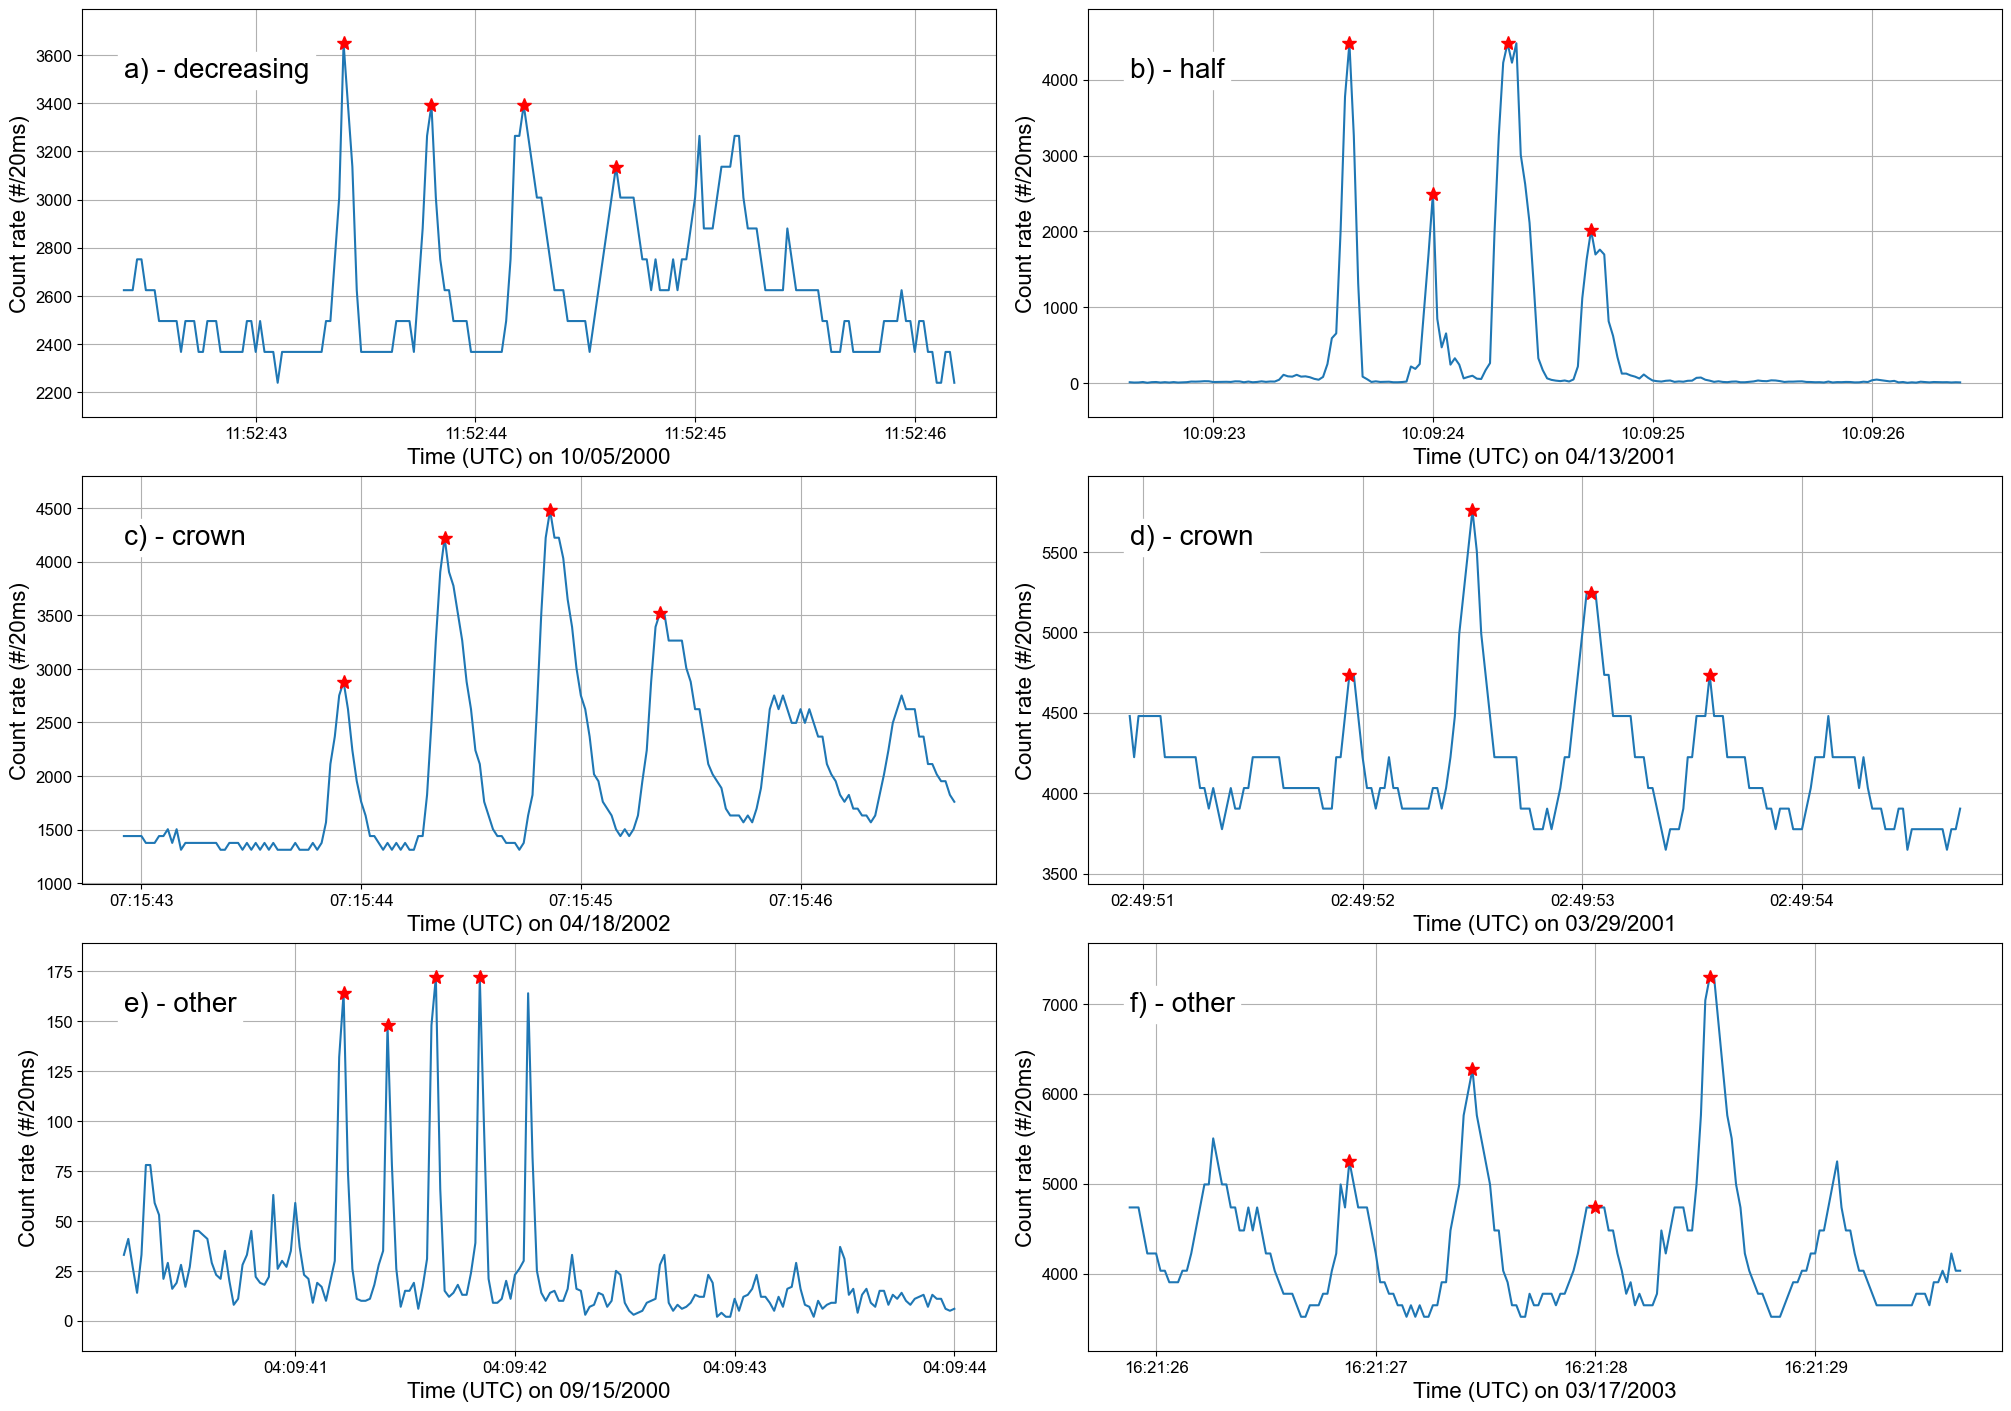

In [2]:
'''
Example event plots
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sampex # thanks to Mike Shumko for making this package
import matplotlib.dates as dates
from scipy.signal import find_peaks

plt.rcParams["font.family"] = "Arial" # bc I don't like the default Python font

def plot_date(ax, j):
    # Function that makes plots of events
    # Author: Max Feinland
    # Date created: not sure, sorry
    # Last modified: 7/23/2024
    
    # Inputs: axes object (which subplot to plot on), iterator variable, 
    # dictionary containing specifics for each plot
    
    # Outputs: none
    
    b1 = 40 # buffer between start time and start of plotting (in indices)
    b2 = 150 # buffer between stop time and end of plotting (in indices)
    t = plotting_data["t"][j] # timestamp of event start
    
    cur_t = pd.to_datetime(t) # convert text to DateTime
    h = sampex.HILT(cur_t) # request SAMPEX count rate data
    h.load()
    
    # find index of where SAMPEX data time matches timestamp
    m = np.where(h.times == cur_t)[0][0]
    d_plot = h.times[m-b1:m+b2]
    r_plot = h.counts[m-b1:m+b2]
    
    maxdis = max(r_plot) - min(r_plot) # range of interval
    # identify peaks in interval
    [pks, _] = find_peaks(r_plot, prominence=0.25*maxdis, distance=3)
    if j in [0, 2, 3]:
        # The actual process of peaks found is a lot more finicky than this,
        # and can be found in the ChorusWaves search script. This version runs
        # a lot faster, albeit less accurately, so this line just fixes any discrepancy
        # between this method and the more robust way.
        pks = pks[0:4]
    elif j in [4]:
        pks = pks[2:6]
    elif j in [5]:
        pks = pks[1:5]
    
    # for plotting
    txt_loc_x = h.times[m-b1]
    txt_loc_y = 0.9*(max(r_plot) - min(r_plot)) + min(r_plot)
    xlbel = "Time (UTC) on " + cur_t.strftime('%m/%d/%Y')
    
    ax.plot(d_plot, r_plot)
    ax.plot(d_plot[pks], r_plot[pks], 'r*', markersize=10)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S')) 
    ax.set_xlabel(xlbel, fontsize=16)
    ax.grid()
    ax.set_ylabel("Count rate (#/20ms)", fontsize=16)
    ax.text(x=txt_loc_x, y=txt_loc_y, s=plotting_data["letter"][j], fontsize=20,
           backgroundcolor="white")
    ax.tick_params(labelsize=12)
    ax.set_ylim((min(r_plot)-0.1*np.ptp(r_plot)), (1.1*np.ptp(r_plot)+min(r_plot)))
    
# read in data
data = pd.read_csv("Data_Files/all_events_v3.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events only
good_data = good_data.reset_index(drop=True)

idx =  [15, 33, 43, 25, 12, 64] # indices of events I picked as examples
plotting_data = {"t": [good_data.t[x] for x in idx], 
                 "letter": ['a) - decreasing', 'b) - half', 'c) - crown', 'd) - crown',
                            'e) - other', 'f) - other']}

fig, ax = plt.subplots(3,2, figsize=(20,14), constrained_layout=True)
ax_flat = ax.flatten()

# iterate through axes object and plot each example event
for j, a in enumerate(ax_flat):
    plot_date(a, j)

plt.savefig('Figures/examples.png')

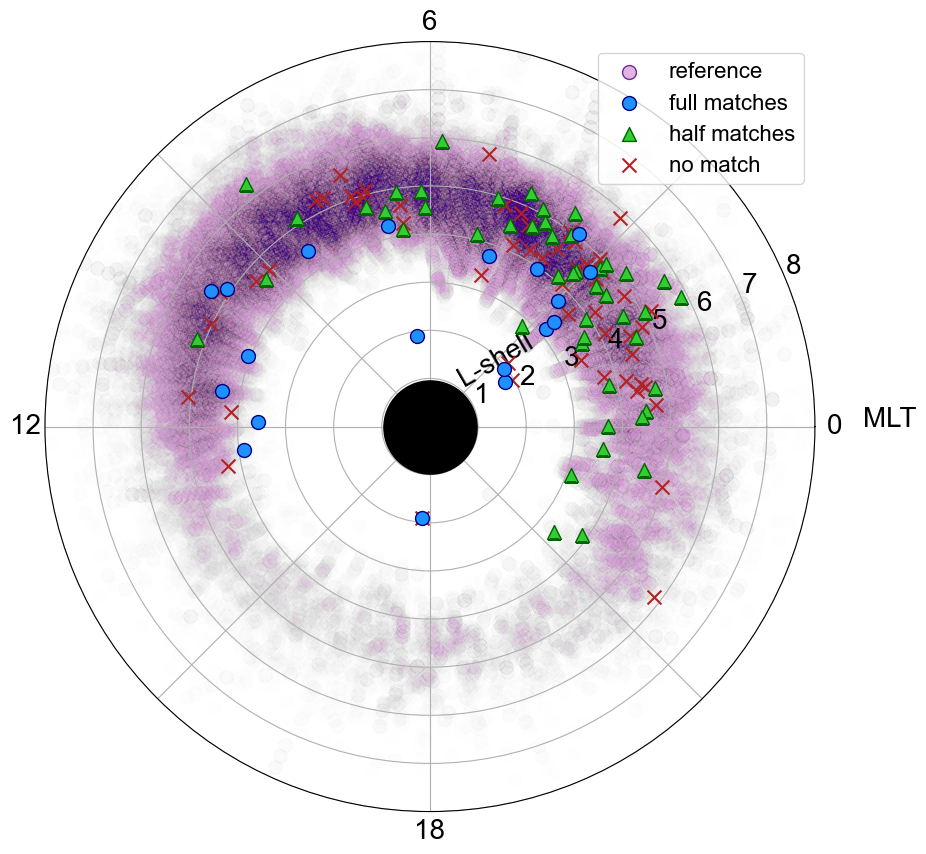

In [3]:
'''
Polar plot of MLT, L-shell
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as dates
from matplotlib.legend_handler import HandlerTuple
import ast
from datetime import datetime
from matplotlib.patches import Circle


plt.rcParams["font.family"] = "Arial"

# Import data
data = pd.read_csv("Data_Files/all_events_v3.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events
good_data = good_data.reset_index(drop=True) # reset index

# spread in model predictions
pers = pd.read_csv("Data_Files/model_pers_2.csv",index_col=0)
spread = pd.DataFrame({'spread': (pers.max(axis=1) - pers.min(axis=1))})
good_data = good_data.join(spread)

# spacings between peaks for each event
s = pd.read_csv("Data_Files/spacings.csv")
s['dt'] = s['dt'].apply(ast.literal_eval)

fullper = np.zeros(len(good_data)) # initialize vector containing full/half classification
diff = np.zeros(len(good_data)) # initialize vector containing difference bw expected & observed

for j in range(len(fullper)):
    num_pks = len(s.dt[j])
    hilt_uncertainty = 0.02 # time resolution of instrument
    err = np.sqrt(good_data.spread[j]**2 + hilt_uncertainty**2) # propagate error

    full_diff = abs(s.dt[j] - good_data.tb[j])
    half_diff = abs(s.dt[j] - good_data.tb[j]/2)

    # are any of the spacings within allowable sigma? t/f (bool)
    full_yn = any([x <= err for x in full_diff])
    half_yn = any([x <= err for x in half_diff])


    # determine if half, full, or no match
    if full_yn & half_yn:
        # Both conditions are true, so figure out which is closer
        if min(full_diff) < min(half_diff):
            fullper[j] = 1
            tb = good_data.tb[j]
            zo = 10
            diff[j] = min(full_diff)
        else:
            fullper[j] = 2
            tb = good_data.tb[j]/2
            zo = 10
            diff[j] = min(half_diff)
    elif full_yn:
        fullper[j] = 1
        tb = good_data.tb[j]
        zo = 10
        diff[j] = min(full_diff)
    elif half_yn:
        fullper[j] = 2
        tb = good_data.tb[j]/2
        zo = 10
        diff[j] = min(half_diff)
    else:
        zo = 5
        if min(full_diff) < min(half_diff):
            tb = good_data.tb[j]
            diff[j] = min(full_diff)
            fullper[j] = 0
        else:
            tb = good_data.tb[j]/2
            diff[j] = min(half_diff)
            fullper[j] = 0

            
# read in data
ref = pd.read_csv("Data_Files/microburst_catalog_00.txt")

# limit reference data to time surveyed by my search script
time_needed = pd.to_datetime(ref['dateTime'])
idx = np.where((time_needed >= datetime(2000, 1, 1)) & (time_needed <= datetime(2003, 12, 31)))[0]
ref = ref.iloc[idx,:]

# Create the plot
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': 'polar'})
# Reference microburst data

ax.scatter(0,0,s=4500,c='k', marker='o', zorder=100)
ax.scatter(0,10, s=100, c='plum', marker='o', alpha=0.8, label='reference', edgecolor='indigo')
# ax.add_patch(Circle((0,0), 1, color='k', zorder=10))
ax.scatter(ref.MLT*np.pi/12, ref.L, s=100, c='plum', marker='o', edgecolor='indigo',
           alpha=0.005, zorder=0)
# Plot my events

ax.scatter(good_data.MLT[fullper==1]*np.pi/12, good_data.L[fullper==1], s=100, c='dodgerblue', 
           marker='o', label='full matches', zorder=100, edgecolor='navy')
ax.scatter(good_data.MLT[fullper==2]*np.pi/12, good_data.L[fullper==2], s=100, c='limegreen',
           marker='^', label='half matches', zorder=50, edgecolor='darkgreen')
ax.scatter(good_data.MLT[fullper==0]*np.pi/12, good_data.L[fullper==0], s=100, c='firebrick', 
           marker='x', label='no match', zorder=10)

# Random formatting stuff
ax.set_rmax(8)
ax.set_rticks(np.arange(0,9), labels=['0', '1', '2', '3', '4', '5', '6', '7', '8'], 
              size=20)  # L shell values
ticklocs = np.pi*np.arange(0, 360, 90)/180
ax.set_xticks(ticklocs.tolist())
ax.set_xticklabels(['0', '6', '12', '18'], fontsize=20)#,color="white")

ax.set_theta_zero_location("E")
ax.grid(True)
ax.legend(fontsize=16, loc='upper right')
ax.set_thetagrids(np.linspace(0,360,9))
# labels (weird for polar plots lol)
plt.text(np.pi/3, 1, 'L-shell', rotation=30, size=20)
plt.text(0, 9, 'MLT', color="black", size=20)

plt.savefig('Figures/mlt_l.png')

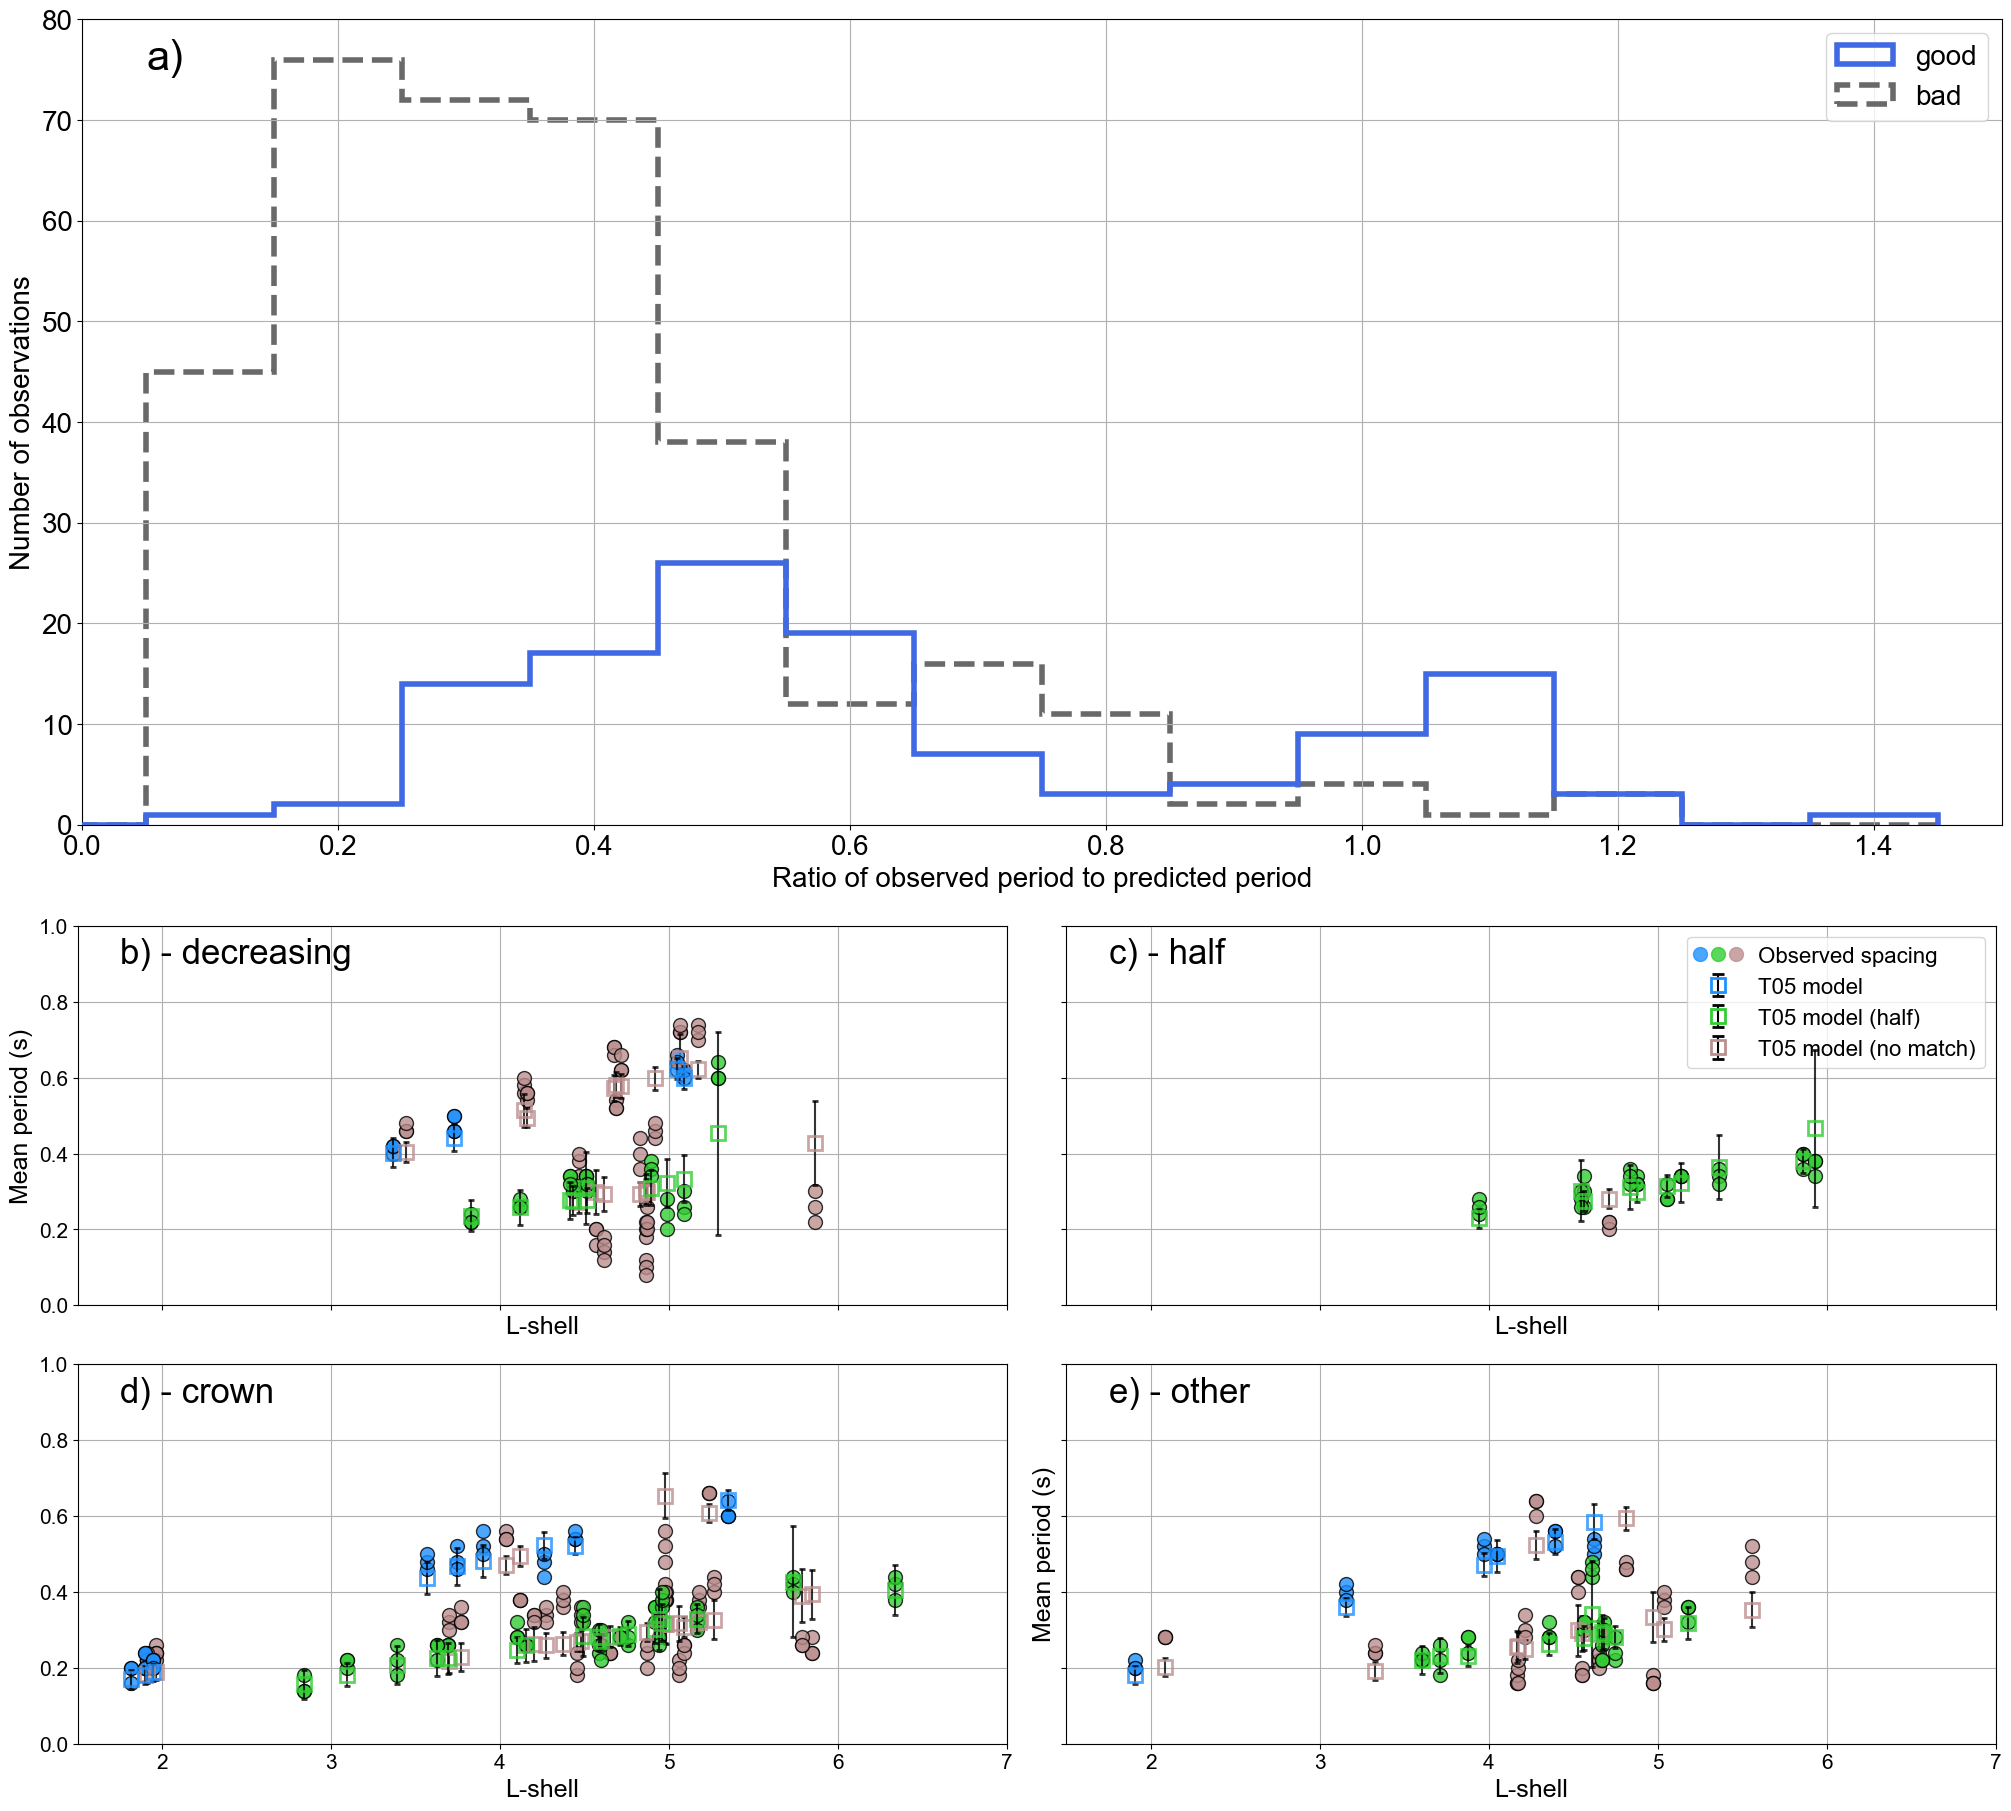

In [4]:
'''
Period vs. L-shell (Figure 3)
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as dates
from matplotlib.legend_handler import HandlerTuple
import ast
import matplotlib.colors as mcolors

plt.rcParams["font.family"] = "Arial"

def plot_specific_shape(ax, k, fullper, norm, cmap, diff, pl1):
    # Function that plots bounce period vs. L shell for a specific shape
    # Author: Max Feinland
    # Date created: sometime in July 2024
    # Last modified: 11/15/2024
    
    # Inputs: axes object (which subplot to plot on), iterator variable
    
    # Outputs: none
    
    current_shape = txt["shapes"][k] # pull stuff out of dict
    current_letter = txt["letter"][k]
    
    # find indices containing allowable shapes
    indices = np.where(good_data.shapes==current_shape)[0]
    
    for j in indices:
        num_pks = len(s.dt[j])
        hilt_uncertainty = 0.02 # time resolution of instrument
        err = np.sqrt(good_data.spread[j]**2 + hilt_uncertainty**2) # propagate error

        full_diff = abs(s.dt[j] - good_data.tb[j])
        half_diff = abs(s.dt[j] - good_data.tb[j]/2)
        
        # are any of the spacings within allowable sigma? t/f (bool)
        full_yn = any([x <= err for x in full_diff])
        half_yn = any([x <= err for x in half_diff])
        
        
        # determine if half, full, or no match
        if full_yn & half_yn:
            # Both conditions are true, so figure out which is closer
            if min(full_diff) < min(half_diff):
                fullper[j] = 1
                edgecol = full_color
                tb = good_data.tb[j]
                zo = 10
                diff[j] = min(full_diff)
            else:
                fullper[j] = 2
                edgecol = half_color
                tb = good_data.tb[j]/2
                zo = 10
                diff[j] = min(half_diff)
        elif full_yn:
            fullper[j] = 1
            edgecol = full_color
            tb = good_data.tb[j]
            zo = 10
            diff[j] = min(full_diff)
        elif half_yn:
            fullper[j] = 2
            edgecol = half_color
            tb = good_data.tb[j]/2
            zo = 10
            diff[j] = min(half_diff)
        else:
            fullper[j] = 0
            edgecol = else_color
            zo = 5
            if min(full_diff) < min(half_diff):
                tb = good_data.tb[j]
                diff[j] = min(full_diff)
            else:
                tb = good_data.tb[j]/2
                diff[j] = min(half_diff)

        # plotting
        handl = ax.scatter(good_data.L[j]*np.ones(len(s.dt[j])), s.dt[j], marker='o', s=100, 
                   c=edgecol, alpha = 0.8, zorder=zo, edgecolor='k')

        ax.errorbar(good_data.L[j], tb, yerr=err, fmt='s', 
                 markerfacecolor='none', capsize=2.5, markeredgecolor=edgecol,
                 zorder=(zo+5), markersize=10, color='black', markeredgewidth=2, alpha=0.8)
    
    
    if current_shape == 'decr':
        shape_label = 'decreasing'
    else:
        shape_label = current_shape
        
    all_label = current_letter + ' - ' + shape_label
    ax.text(1.75, 0.9, all_label, fontsize=25) # subplot label
    ax.grid()
    
    ax.set_xlabel("L-shell", fontsize=18)
    if k in [0, 3]: # put ylabel on leftmost 2 plots
        ax.set_ylabel("Mean period (s)", fontsize=18)
    ax.set_ylim(0, 1)
    ax.set_xlim(1.5, 7)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    return handl

# Import data
data = pd.read_csv("Data_Files/all_events_v3.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events
good_data = good_data.reset_index(drop=True) # reset index

# spread in model predictions
pers = pd.read_csv("Data_Files/model_pers_2.csv",index_col=0)
spread = pd.DataFrame({'spread': (pers.max(axis=1) - pers.min(axis=1))})
good_data = good_data.join(spread)

# spacings between peaks for each event
s = pd.read_csv("Data_Files/spacings.csv")
s['dt'] = s['dt'].apply(ast.literal_eval)
newper = [np.min(x) for x in s.dt] # data.per is min per, use this instead

# portion of particles in loss cone
pll = pd.read_csv("Data_Files/pll.csv", index_col=0)
pl1 = pll.portion_losscone_1
pl2 = pll.portion_losscone_2

# Shared color normalization and colormap
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.viridis  

# Making figures
fig = plt.figure(layout='constrained', figsize=(20,18))
subfigs = fig.subfigures(2, 1, wspace=0.07)

## First figure: bounce period histograms
ax1 = subfigs[0].subplots()

# Calculate period ratios 
good_ratio = np.divide(newper, good_data.tb)
bad_ratio = np.divide(data.per[data.final_eye>1.5], data.tb[data.final_eye>1.5])

ax1.hist(good_ratio, bins=15, range=(-0.05,1.45), color='royalblue', histtype='step', linewidth=4,
        linestyle='-', zorder=10, label='good') # good histogram
ax1.hist(bad_ratio, bins=15, range=(-0.05,1.45), color='dimgrey', histtype='step', linewidth=4,
         linestyle='--', zorder=0, label='bad') # bad histogram

# axis labels & ticks
ax1.set_xlabel("Ratio of observed period to predicted period", fontsize=20)
ax1.set_ylabel("Number of observations", fontsize=20)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.legend(fontsize=20)
ax1.grid()
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 80)
ax1.text(0.05, 75, 'a)', fontsize=30) # subplot label

# Second figure: bounce period vs. L for each shape
ax2 = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
ax_flat = ax2.flatten()

txt = {"shapes": ["decr", "half", "crown", "other"],
      "letter": ["b)", "c)", "d)", "e)"]}

full_color = 'dodgerblue'
half_color = 'limegreen'
else_color = 'rosybrown'

fullper = np.zeros(len(good_data)) # initialize vector containing full/half classification
diff = np.zeros(len(good_data)) # initialize vector containing difference bw expected & observed
norm = mcolors.Normalize(vmin=0, vmax=1)
# iterate through axes object and plot each shape type
for j, a in enumerate(ax_flat):
    handle = plot_specific_shape(a, j, fullper, norm, cmap, diff, pll.portion_losscone_1)


p = ax2[0,1]
p1, = p.plot(0, 0, 'o', color=full_color, alpha=0.8, markersize=10)
p2, = p.plot(0, 0, 'o', color=half_color, alpha=0.8, markersize=10)
p3, = p.plot(0, 0, 'o', color=else_color, alpha=0.8, markersize=10)

f = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=full_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
h = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=half_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
x = p.errorbar(0, 0, yerr=0.2, fmt='s', markeredgecolor=else_color, markerfacecolor='none',
               color='black', markersize=10, capsize=4, markeredgewidth=2)
l = p.legend([(p1, p2, p3), f, h, x], # i made the legend look nice
         ['Observed spacing', 'T05 model', 'T05 model (half)',  'T05 model (no match)'], 
         handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16, loc='upper right')

plt.savefig('Figures/tb.png')

In [5]:
def isleap(year):
    return year % 4 == 0

def dayarrayfun():
    """Generate a DataFrame of day and year values."""
    start_year = 1996
    start_day = 160
    end_year = 2012
    end_day = 283
    spacing = 27

    days_array = []
    years_array = []

    current_year = start_year
    current_day = start_day

    while current_year < end_year or (current_year == end_year and current_day <= end_day):
        # Determine the number of days in the current year
        num_days = 366 if isleap(current_year) else 365
        
        # Append the current day and year to the arrays
        days_array.append(current_day)
        years_array.append(current_year)
        
        # Increment the current day by the spacing
        current_day += spacing
        if current_day > num_days:
            current_day -= num_days
            current_year += 1

    y = [str(x) + str(y) for x, y in zip(years_array, days_array)]
    dates = pd.to_datetime(y, format='%Y%j')
    days_df = pd.DataFrame({'dates': dates, 'y_col': years_array, 'd_col': days_array})
    return days_df

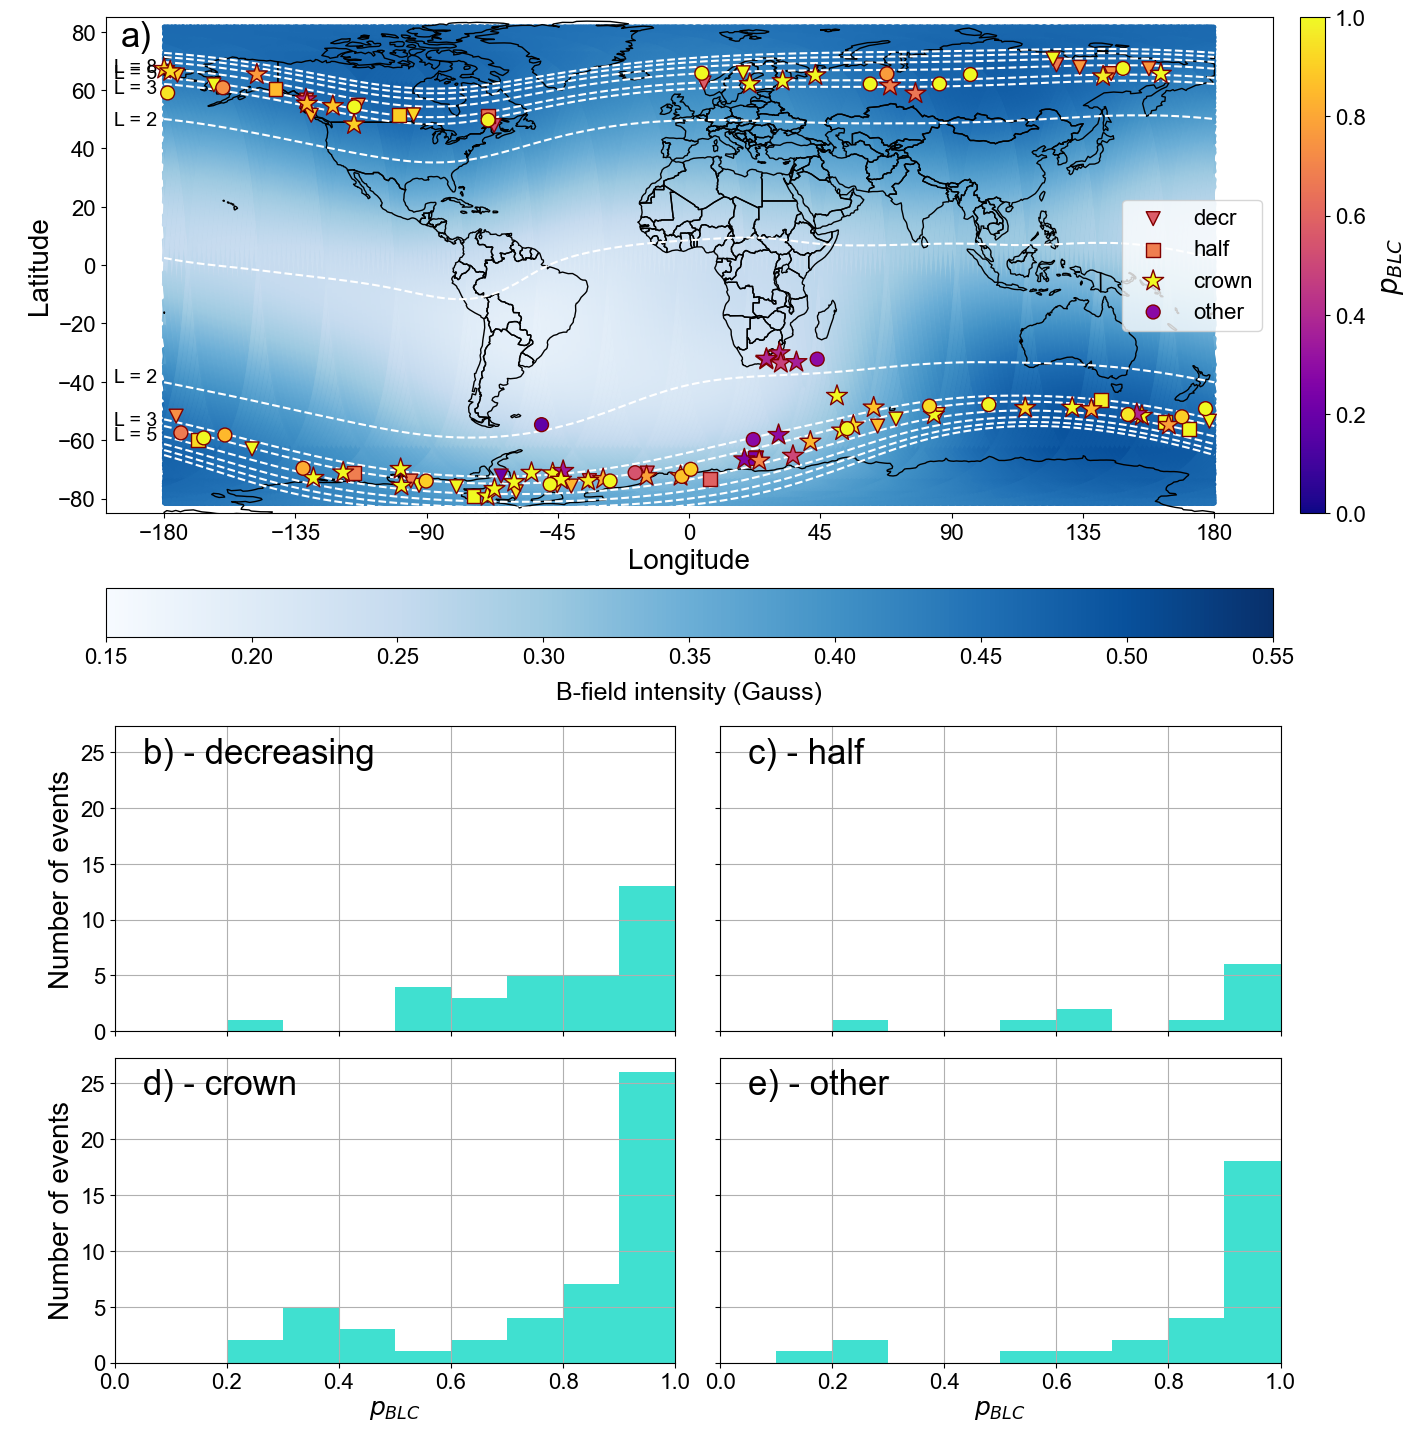

In [6]:
'''Create magnetic field background'''
import pandas as pd
import numpy as np
import sampex
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta

plt.rcParams["font.family"] = "Arial" # because I don't like the default Python font

# Load attitude data for time
def load_att(t):
    days_df = dayarrayfun()
    pathname = '/Users/maxim/sampex-data/Attitude/'
    att_row = np.where(days_df['dates'] < t)[0][-1] # find the right row in the ephemeris files
    day1str = str(days_df['d_col'][att_row])
    day2str = str(days_df['d_col'][att_row+1]-1)
    
    # checking if leading zeroes are needed
    if len(day1str) == 1:
        day1str = '00' + day1str
    elif len(day1str) == 2:
        day1str = '0' + day1str

    if len(day2str) == 1:
        day2str = '00' + day2str
    elif len(day2str) == 2:
        day2str = '0' + day2str
        
    filename = 'PSSet_6sec_' + str(days_df['y_col'][att_row]) + day1str + '_' + \
                str(days_df['y_col'][att_row+1]) + day2str + '.txt'
    
    try: # if you have the file already
        att = pd.read_csv(pathname + filename, sep=' ', header=60, on_bad_lines='skip')
    except: # no file?
        a = sampex.Attitude(t) # download da file
        att = pd.read_csv(pathname + filename, sep=' ', header=60, on_bad_lines='skip')

    cols = np.array([7, 8, 21]) # take out lat, lon, b-field intensity
    att = att.iloc[:, cols] 
    att.columns = ['lon', 'lat', 'b']

    # change longitude to be -180 to 180 (rather than 0 to 360)
    lon_idx = np.where(att.lon > 180)[0]
    att.loc[lon_idx, 'lon'] = att.lon[lon_idx] - 360
    return att

t_i = '2001-1-1' # date for which we'll use the whole 27-day ephemeris file

yes_load = True

if yes_load:
    att = load_att(t_i)

# PLOT THAT THANG
fig = plt.figure(layout='constrained', figsize=(14,14.2))

## SUBFIGURE 1: Locations
subfigs = fig.subfigures(2, 1, wspace=0.07)
ax = subfigs[0].subplots()

shapefile = 'Data_Files/ne_110m_admin_0_countries_lakes.shp'
world = gpd.read_file(shapefile)

b_cm = plt.cm.Blues

# Plot magnetic field intensity
bfield = ax.scatter(att.lon, att.lat, s=5, c=att.b, cmap = b_cm, vmin=0.15, vmax=0.55)
cax = ax.inset_axes([0, -0.25, 1, 0.1])
b_cbar = plt.colorbar(bfield, cax=cax, orientation='horizontal')
b_cbar.set_label("B-field intensity (Gauss)", fontsize=18, labelpad=10)
b_cbar.ax.tick_params(labelsize=16)
world.plot(ax=ax, color='none', edgecolor='black', zorder=5)

# Formatting shenanigans
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_ylim(-85, 85)
ax.set_xlim(-200, 200)

# Plot L-shell contours
lgrid = pd.read_csv('Data_Files/Lgrid.dat', delimiter='\t', header=None)
for i in np.arange(1, 30, 2):
    min_pos = np.argmin(lgrid.iloc[:,i])
    latl = np.concatenate(([lgrid.iloc[min_pos:,i-1], lgrid.iloc[:min_pos,i-1]]))
    lonl = np.concatenate(([lgrid.iloc[min_pos:,i], lgrid.iloc[:min_pos,i]]))
    ax.plot(lonl, latl, '--', color="white", zorder=5)

# Add L-shell contour labels
l_labels = {'lat': [48, -40, 59, -55, 64, -60, 66],
           'name': ['L = 2', 'L = 2', 'L = 3', 'L = 3', 'L = 5', 'L = 5', 'L = 8']}
l_lon = -197
for i in range(len(l_labels['lat'])):
    ax.text(l_lon, l_labels['lat'][i], l_labels['name'][i], fontsize=14, zorder=50)


# Import event data
data = pd.read_csv("Data_Files/all_events_v3.csv", index_col=0)
good_data = data[data.final_eye<2] # restrict to good events
good_data = good_data.reset_index(drop=True) # reset index

pll = pd.read_csv('Data_Files/pll.csv', index_col=0) # portion of particles inside loss cone
pl1 = pll.portion_losscone_1
    
plot_dict = {'shape': ['decr', 'half', 'crown', 'other'],
            'marker': ['v', 's', '*', 'o'],
            'size': [100, 100, 250, 100]}
gds = good_data.shapes

h1, h2, h3, h4 = [], [], [], []
handle_list = [h1, h2, h3, h4]

cm = plt.cm.plasma

for j in range(4):
    idx = gds==plot_dict['shape'][j]
    handle_list[j] = ax.scatter(good_data.lon[idx], good_data.lat[idx], marker=plot_dict['marker'][j],
                                s=plot_dict['size'][j], c=pl1[idx], zorder=50, edgecolor='maroon',
                                label=plot_dict['shape'][j], cmap = cm, vmin=0, vmax=1)
    
cbar = fig.colorbar(handle_list[0], ax=ax, orientation='vertical', pad=0.005)
cbar.set_label("$p_{BLC}$", fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=16)
ax.legend(handles=handle_list, loc='right', fontsize=16)
_ = ax.text(-195, 75, 'a)', fontsize=25)
ax.tick_params(axis='both', labelsize=16)
ax.set_xticks(np.arange(-180,181,45))


## SUBFIGURE 2: HISTOGRAMS

subfigsnest = subfigs[1].subfigures(1,3, width_ratios=[0.02, 1, 0.08])
ax2 = subfigsnest[1].subplots(2, 2, sharex=True, sharey=True)

def plot_specific_shape_hist(ax, k, pl1):
    
    current_shape = txt["shapes"][k] # pull stuff out of dict
    current_letter = txt["letter"][k]
    
    # find indices containing allowable shapes
    indices = np.where(good_data.shapes==current_shape)[0]
    
    handl = ax.hist(pl1[indices], color='turquoise', bins=10, range=(0,1))
    
    if current_shape == 'decr':
        shape_label = 'decreasing'
    else:
        shape_label = current_shape
        
    all_label = current_letter + ' - ' + shape_label
    ax.text(0.05, 24, all_label, fontsize=25) # subplot label
    ax.grid()
    
    if k in [2, 3]:
        ax.set_xlabel("$p_{BLC}$", fontsize=18)
    if k in [0, 2]:
        ax.set_ylabel("Number of events", fontsize=20)
    ax.set_xlim(0, 1)
    return handl

txt = {"shapes": ["decr", "half", "crown", "other"],
      "letter": ["b)", "c)", "d)", "e)"]}

ax_flat = ax2.flatten()
for j, a in enumerate(ax_flat):
    handle = plot_specific_shape_hist(a, j, pl1)
    a.tick_params(axis='both', labelsize=16)

plt.savefig('Figures/losscone.png')